In [1]:
import pandas as pd
import os
import math
import re
from collections import Counter
from scipy import stats

import nltk
import yaml

nltk.download('stopwords')
from nltk.corpus import stopwords

# Generate Unlabeled Data

In [2]:
datadir = '../data/sample'
wikidf = []
newsdf = []

for file in os.listdir(datadir):
    if 'wiki' in file: 
        df = pd.read_csv(datadir + '/' + file)[['news_id', 'title', 'wiki', 'entity']]
        
        # add date column
        date = '-'.join(file.split('-')[0:3])
        df['date'] = date
        
        # remove duplicates
        df.drop_duplicates(['title', 'news_id', 'date'])
        
        # set index
        df = df.reset_index()
        df.rename(columns={'index': 'wiki_id'}, inplace=True)
        wikidf.append(df)
    elif 'news' in file:
        df = pd.read_csv(datadir + '/' + file)[['news_id', 'news']]
        date = '-'.join(file.split('-')[0:3])
        df['date'] = date
        newsdf.append(df)
        
data = pd.concat(wikidf).merge(pd.concat(newsdf))
data = data[['news_id', 'wiki_id', 'date', 'news', 'entity', 'title', 'wiki']]
data = data.sort_values(['date', 'news_id', 'wiki_id'])
# data.to_csv('unlabeled_data.csv', index=False)

# Evaluate Labeled Data

In [5]:
labeled = pd.read_csv('../data/labeled/labeled.csv')
labeled = labeled.dropna()
labeled.head()

,news_id,wiki_id,date,news,title,wiki,label
0,0,0,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,First 100 days of Donald Trump's presidency,The first 100 days of Donald Trump's presidenc...,0
1,0,1,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Timeline of the Donald Trump presidency (2017 Q2),The following is a timeline of the presidency ...,0
2,0,2,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Apple,An apple is an edible fruit produced by an app...,0
3,0,3,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Apple Inc.,Apple Inc. is an American multinational techno...,1
4,0,4,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Treasury,A treasury is either\n\nA government departmen...,0


In [23]:
def remove_stopwords(df, c):

    stop_words = stopwords.words('english')
    for raw, processed in zip(c['raw_features'], c['processed_features']):
        df[processed] = df[raw].str.lower().str.split(). \
            apply(lambda x: ' '.join([item for item in x
                                      if item not in stop_words]))
    return df


with open('../config/algorithm.yaml', 'r') as f:
    c = yaml.load(f, Loader=yaml.FullLoader)

for raw, processed in zip(c['raw_features'], c['processed_features']):
    labeled[processed] = labeled[raw].str.lower().str.split(). \
        apply(lambda x: ' '.join([item for item in x
                                  if item not in stop_words]))

labeled = labeled.dropna()
labeled = remove_stopwords(labeled, c)
labeled.head()

,news_id,wiki_id,date,news,title,wiki,label,wiki_process,news_process,cos_sim,sm_sim,predict
0,0,0,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,First 100 days of Donald Trump's presidency,The first 100 days of Donald Trump's presidenc...,0,first 100 days donald trump's presidency began...,market rally split again; yellen tries walk ba...,0.096800,0.078384,False
1,0,1,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Timeline of the Donald Trump presidency (2017 Q2),The following is a timeline of the presidency ...,0,following timeline presidency donald trump sec...,market rally split again; yellen tries walk ba...,0.106102,0.078501,False
2,0,2,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Apple,An apple is an edible fruit produced by an app...,0,apple edible fruit produced apple tree (malus ...,market rally split again; yellen tries walk ba...,0.063492,0.115635,True
3,0,3,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Apple Inc.,Apple Inc. is an American multinational techno...,1,apple inc. american multinational technology c...,market rally split again; yellen tries walk ba...,0.114876,0.090504,False
4,0,4,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Treasury,A treasury is either\n\nA government departmen...,0,treasury either government department related ...,market rally split again; yellen tries walk ba...,0.122077,0.079545,False


In [10]:
def sim_sm(x):
    from difflib import SequenceMatcher
    return SequenceMatcher(None, x[0], x[1]).ratio()


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    WORD = re.compile(r"\w+")
    words = WORD.findall(text)
    return Counter(words)


def cos_pipeline(x):
    vector1 = text_to_vector(x[0])
    vector2 = text_to_vector(x[1])

    return get_cosine(vector1, vector2)


<AxesSubplot:>

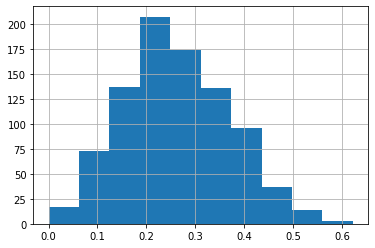

In [13]:
labeled['cos_sim'] = labeled[['wiki', 'news']].apply(cos_pipeline, axis=1)
labeled['cos_sim'].hist()

<AxesSubplot:>

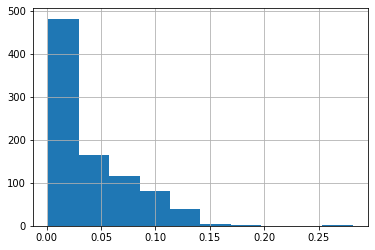

In [14]:
labeled['sm_sim'] = labeled[['wiki', 'news']].apply(sim_sm, axis=1)
labeled['sm_sim'].hist()

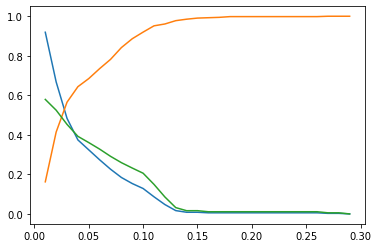

In [16]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt

sensitivities = []
specificities = []
f1s = []
aucs = []
accuracies = []

cutoffs = np.arange(0.01, 0.3, 0.01)
for cutoff in cutoffs:

    labeled['predict'] = labeled['sm_sim'] > cutoff
    labeled['predict'] = labeled['predict'].astype(int)

    cm1 = confusion_matrix(labeled['label'], labeled['predict'])
    total1=sum(sum(cm1))

    ### from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    accuracies.append(accuracy1)
    
    # true positives
    sensitivity1 = cm1[0,0]/(cm1[0,0] + cm1[0,1])
    sensitivities.append(sensitivity1)

    # true negatives
    specificity1 = cm1[1,1]/(cm1[1,0] + cm1[1,1])
    specificities.append(specificity1)

    auc = roc_auc_score(labeled['label'], labeled['predict'])
    aucs.append(auc)

    f1s.append(f1_score(labeled['label'], labeled['predict']))
    
plt.plot(cutoffs, specificities)
plt.plot(cutoffs, sensitivities)
plt.plot(cutoffs, f1s)
plt.show()

In [17]:
maxpos = np.argmax(f1s)
print(np.max(f1s), cutoffs[maxpos])

0.579225352112676


0.01

In [20]:
labeled['predict'] = (labeled['sm_sim'] > 0.1)
labeled.loc[labeled['predict']]['label'].value_counts()

1    46
0    43
Name: label, dtype: int64

In [22]:
labeled.drop_duplicates(['news_id', 'title']).loc[labeled['predict']].head()

,news_id,wiki_id,date,news,title,wiki,label,wiki_process,news_process,cos_sim,sm_sim,predict
2,0,2,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Apple,An apple is an edible fruit produced by an app...,0,apple edible fruit produced apple tree (malus ...,market rally split again; yellen tries walk ba...,0.063492,0.115635,True
7,0,7,May-04-2021,Market Rally Split Again; Yellen Tries To Walk...,Janet Yellen,"Janet Louise Yellen (born August 13, 1946) is ...",1,"janet louise yellen (born august 13, 1946) ame...",market rally split again; yellen tries walk ba...,0.131165,0.108108,True
73,8,73,May-04-2021,Derek Chauvin files motion for new trial in Ge...,Trial of Derek Chauvin,State of Minnesota v. Derek Michael Chauvin is...,1,state minnesota v. derek michael chauvin crimi...,derek chauvin files motion new trial george fl...,0.406180,0.100376,True
110,12,110,May-04-2021,Anger mounts as death toll from Mexico metro o...,Anger management,Anger management is a psycho-therapeutic progr...,0,anger management psycho-therapeutic program an...,anger mounts death toll mexico metro overpass ...,0.214665,0.109177,True
116,14,116,May-04-2021,Judge orders release of secret DOJ memo used t...,Roseanne Barr,"Roseanne Cherrie Barr (born November 3, 1952) ...",0,"roseanne cherrie barr (born november 3, 1952) ...",judge orders release secret doj memo used clea...,0.215181,0.139030,True
